# 3. 模型解釋與 SHAP 分析

## 分類報與混淆矩陣

分類報告：
              precision    recall  f1-score   support

       Bumps       0.62      0.77      0.69        81
   Dirtiness       0.65      1.00      0.79        11
    K_Scatch       0.99      0.95      0.97        78
Other_Faults       0.88      0.50      0.64       135
      Pastry       0.45      0.84      0.59        32
      Stains       0.75      0.86      0.80        14
   Z_Scratch       0.84      0.97      0.90        38

    accuracy                           0.75       389
   macro avg       0.74      0.84      0.77       389
weighted avg       0.80      0.75      0.75       389

混淆矩陣：


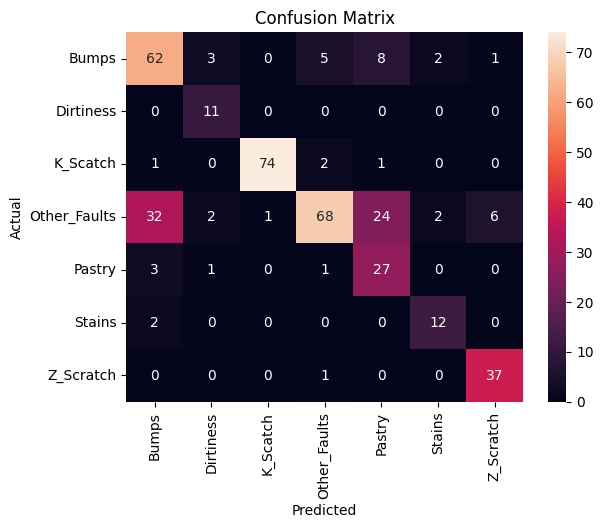

In [122]:

from sklearn.metrics import classification_report, confusion_matrix
y_pred = best_model.predict(X_test_reduced)

print("分類報告：")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

print("混淆矩陣：")
sns.heatmap(confusion_matrix(y_test_enc, y_pred), annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## ROC 曲線比較

### 📊 ROC 曲線解讀說明

ROC（Receiver Operating Characteristic）曲線是評估分類模型的重要工具。

- **X 軸：False Positive Rate（FPR）** = 假陽性率
- **Y 軸：True Positive Rate（TPR）** = 召回率（Recall）

#### ✅ 解讀方式：

| 現象 | 解釋 |
|------|------|
| 曲線越靠左上角 | 模型分類效果越好 |
| 曲線貼近對角線 | 模型效果接近亂猜 |
| 曲線下面積（AUC）越大 | 模型整體判別能力越強 |
| AUC = 1.0 | 完美分類器 |
| AUC = 0.5 | 沒分類能力，與隨機一樣 |

#### 📌 實務應用建議：

- **AUC** 是評估「模型整體分類能力」的好指標
- 若任務強調「不能漏判」，需額外看 **Recall** 與 **PR Curve**

### Macro-average ROC Curve（主圖）

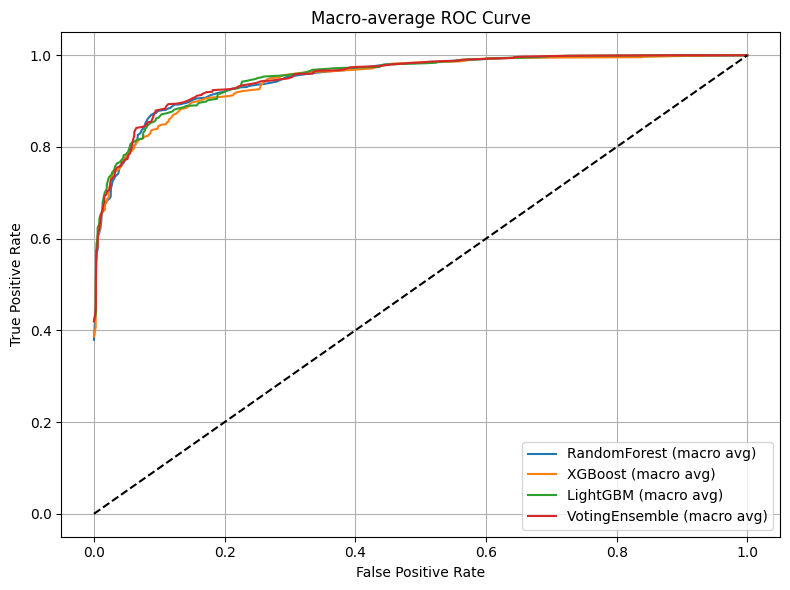

In [123]:
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_macro_average_roc(models, X_test, y_test_enc):
    y_bin = label_binarize(y_test_enc, classes=np.unique(y_test_enc))
    n_classes = y_bin.shape[1]

    plt.figure(figsize=(8, 6))
    for name, model in models.items():
        y_score = model.predict_proba(X_test)

        fpr, tpr = {}, {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes

        plt.plot(all_fpr, mean_tpr, label=f"{name} (macro avg)")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Macro-average ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_macro_average_roc(models, X_test_reduced, y_test_enc)

### 每一類別的 ROC Curve

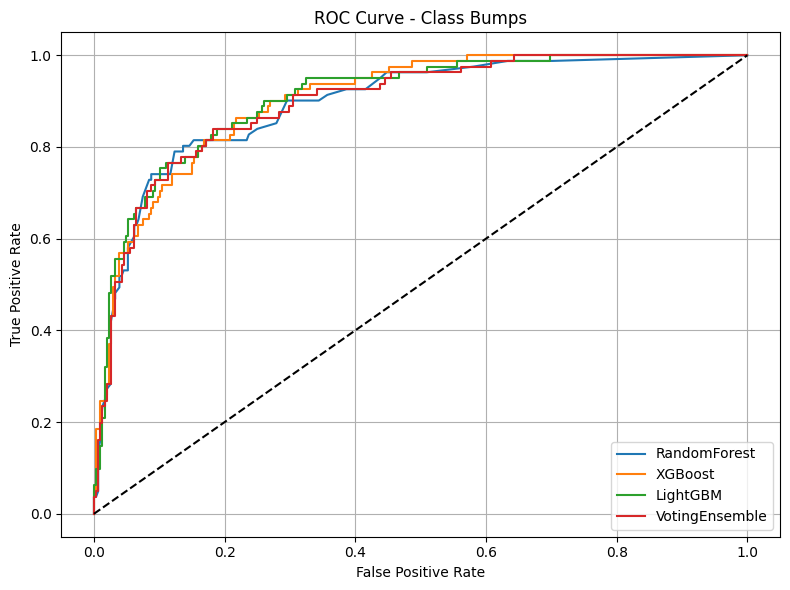

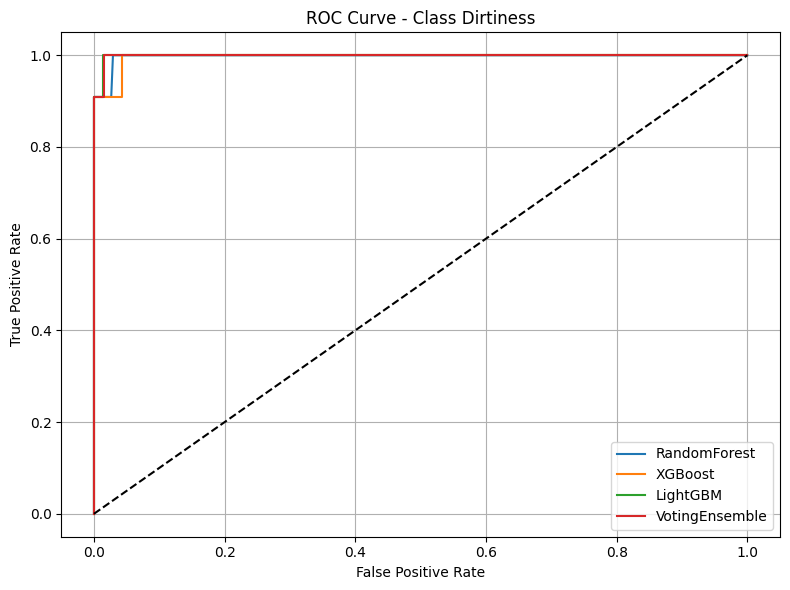

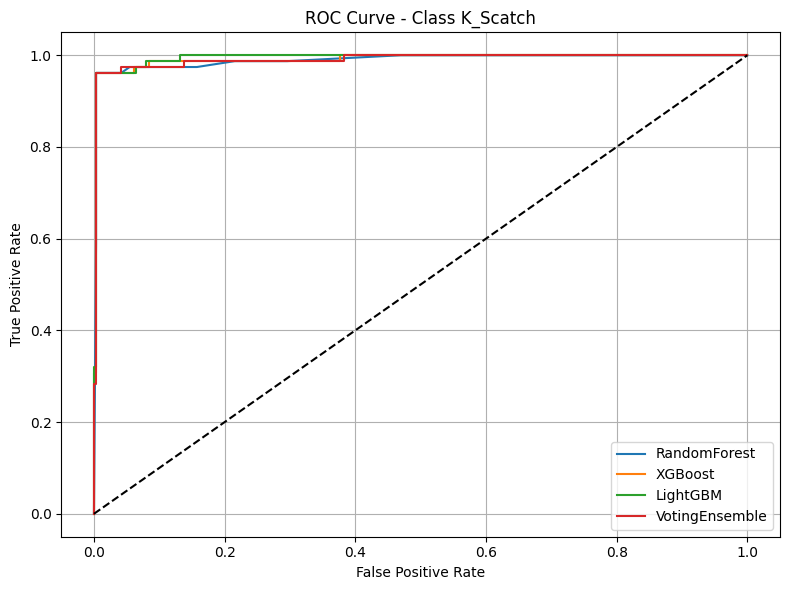

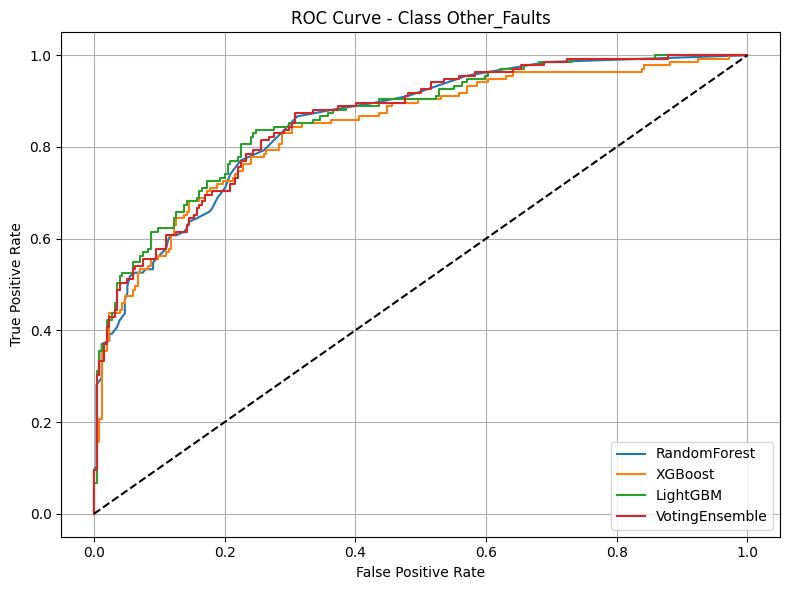

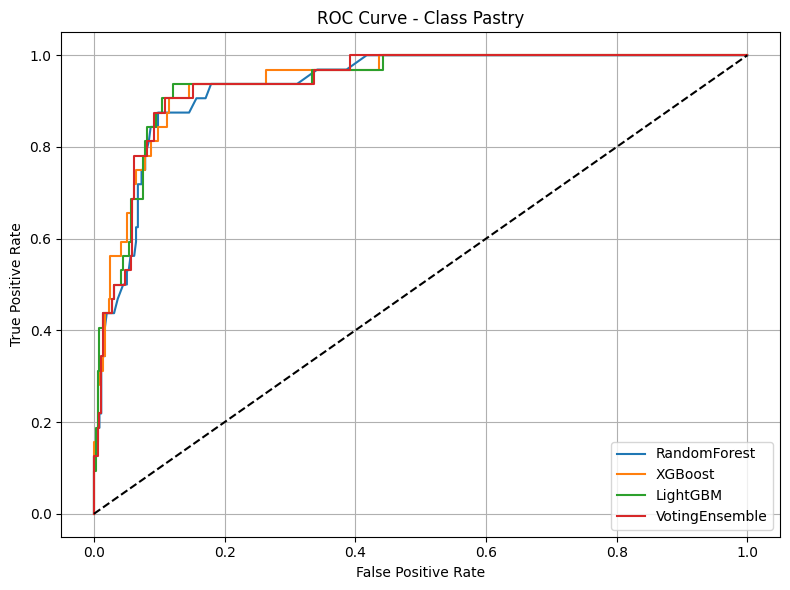

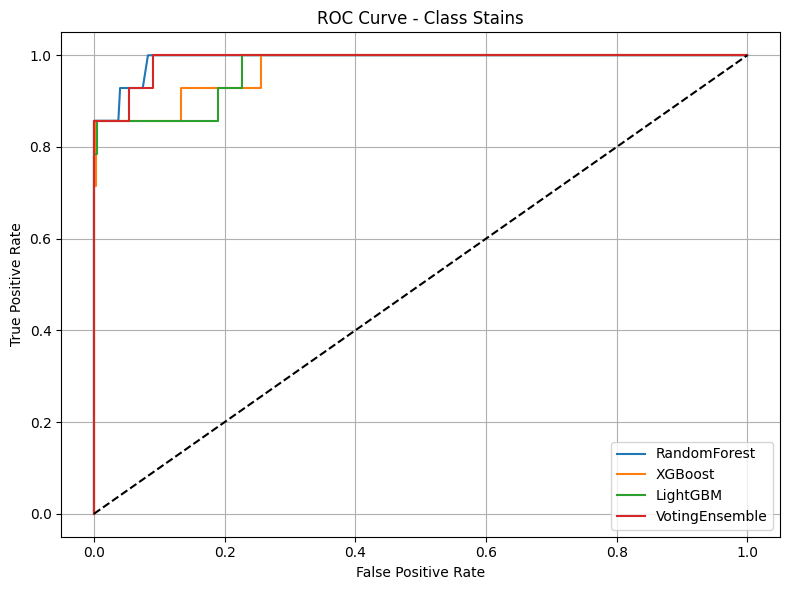

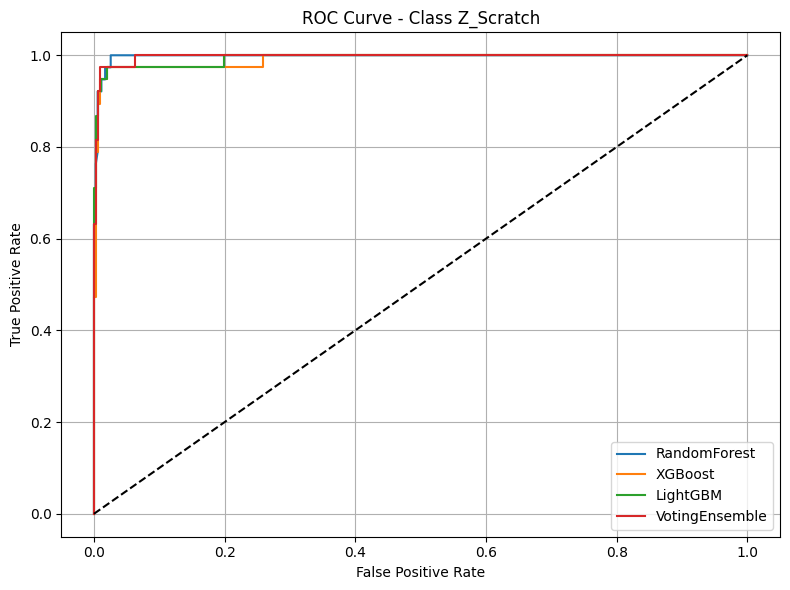

In [124]:
def plot_roc_per_class(models, X_test, y_test_enc, label_encoder):
    n_classes = len(label_encoder.classes_)

    for class_idx in range(n_classes):
        class_name = label_encoder.inverse_transform([class_idx])[0]  # 🔁 將 0 → 'Crack' 這類
        plt.figure(figsize=(8, 6))
        for name, model in models.items():
            y_score = model.predict_proba(X_test)[:, class_idx]
            y_true = (y_test_enc == class_idx).astype(int)
            fpr, tpr, _ = roc_curve(y_true, y_score)
            plt.plot(fpr, tpr, label=f"{name}")

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - Class {class_name}")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_roc_per_class(models, X_test_reduced, y_test_enc, le)

### 📈 模型表現分析：ROC 曲線解讀

#### 🔷 Macro-average ROC Curve

- 每條線代表一個模型的 Macro-average ROC 表現（多類別平均）
- 越靠左上角表示模型整體分類能力越好
- 所有模型 AUC 均優於 0.90，表現穩定

![Macro ROC](roc_macro_average.png)

---

#### 🔍 各類別 ROC Curve 解讀
Pastry,Z_Scratch,,Stains,Other_Faults
| 類別 | 圖片 | AUC 表現 | 評論 |
|------|------|----------|------|
| Bumps | ![Bumps](roc_class_0.png) | 0.90+ | 分類準確，模型表現穩定 |
| Dirtiness | ![Dirtiness](roc_class_1.png) | ~1.00 | 幾乎完美分類，特徵非常明顯 |
| K_Scatch | ![K_Scatch](roc_class_2.png) | ~1.00 | 易於辨識，模型表現極佳 |
| Other_Faults | ![Other_Faults](roc_class_3.png) | 0.85+ | 表現略低，建議檢查錯誤樣本或特徵品質 |
| Pastry | ![Pastry](roc_class_4.png) | 0.95+ | 類別可辨識度高，分類準確 |
| Stains | ![Stains](roc_class_5.png) | 0.95+ | 模型能穩定預測 |
| Z_Scratch | ![Z_Scratch](roc_class_6.png) | ~1.00 | 幾乎完美，模型高度信心預測 |

---

#### ✅ 解讀總結

- VotingEnsemble 在大多數類別中表現優異，是整體表現最佳的模型
- Dirtiness、K_Scatch、Z_Scratch 是最容易被模型區分的類別
- Other_Faults 為最具挑戰的類別，後續可針對該類型進行特徵優化或數據品質檢查
- 使用 ROC 曲線能有效了解模型在不同類別上的區分能力

---


## PR Curve（Precision-Recall 曲線）

### 🔎 Precision-Recall (PR) 曲線解讀

PR Curve 是另一個重要的分類評估工具，特別適合處理類別不平衡的任務。

- **X 軸：Recall（召回率）** → 模型抓對正類的能力
- **Y 軸：Precision（精確率）** → 模型預測為正類的準確性

#### ✅ 解讀方式：

| 現象 | 解釋 |
|------|------|
| 曲線越靠右上角 | 模型同時有高精確率與高召回率 |
| 曲線下方面積（AP）越大 | 模型表現越好 |
| 僅適合看「正類」的分類品質 | 特別適合不平衡資料集任務（如異常偵測） |

#### 📌 實務應用建議：

- **Recall 很重要時（如醫療/異常）** → PR Curve 是比 ROC 更有參考性的工具
- AP 值越大代表模型對「特定類別」分類越穩定

### Macro-average PR Curve（主圖）

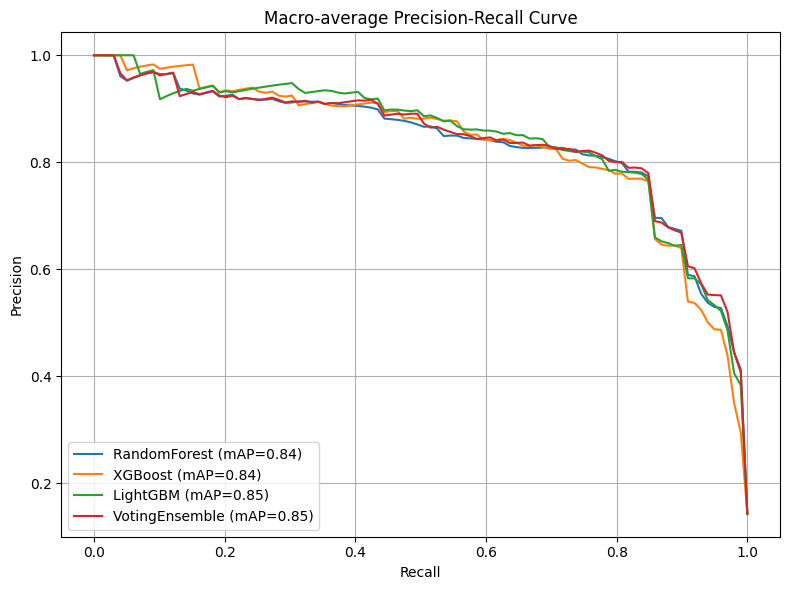

In [125]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_macro_average_pr(models, X_test, y_test_enc):
    y_bin = label_binarize(y_test_enc, classes=np.unique(y_test_enc))
    n_classes = y_bin.shape[1]

    plt.figure(figsize=(8, 6))
    for name, model in models.items():
        y_score = model.predict_proba(X_test)
        precision, recall, ap_list = [], [], []

        for i in range(n_classes):
            p, r, _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
            ap = average_precision_score(y_bin[:, i], y_score[:, i])
            ap_list.append(ap)

            # 為了 macro average，需對 recall 做插值對齊
            recall_interp = np.linspace(0, 1, 100)
            precision_interp = np.interp(recall_interp, r[::-1], p[::-1])
            precision.append(precision_interp)

        mean_precision = np.mean(precision, axis=0)
        mean_ap = np.mean(ap_list)

        plt.plot(recall_interp, mean_precision, label=f"{name} (mAP={mean_ap:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Macro-average Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_macro_average_pr(models, X_test_reduced, y_test_enc)

### 每一類 PR Curve

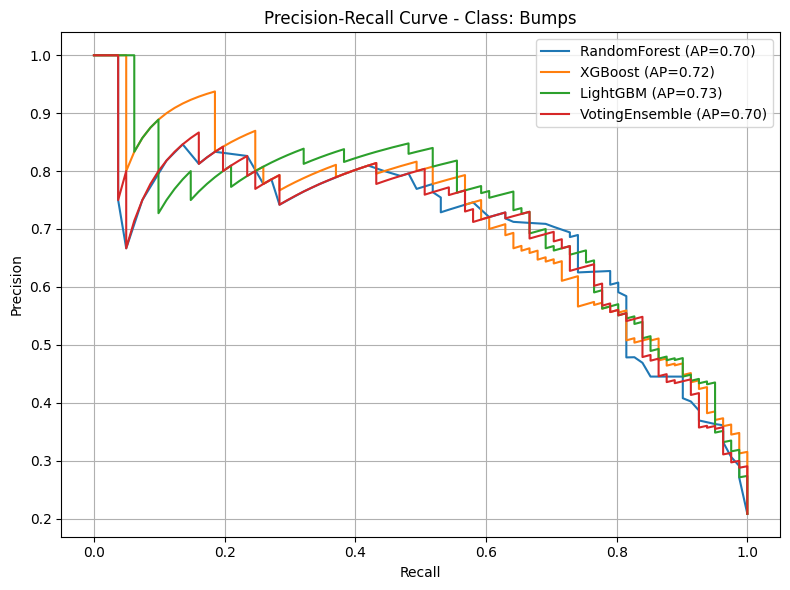

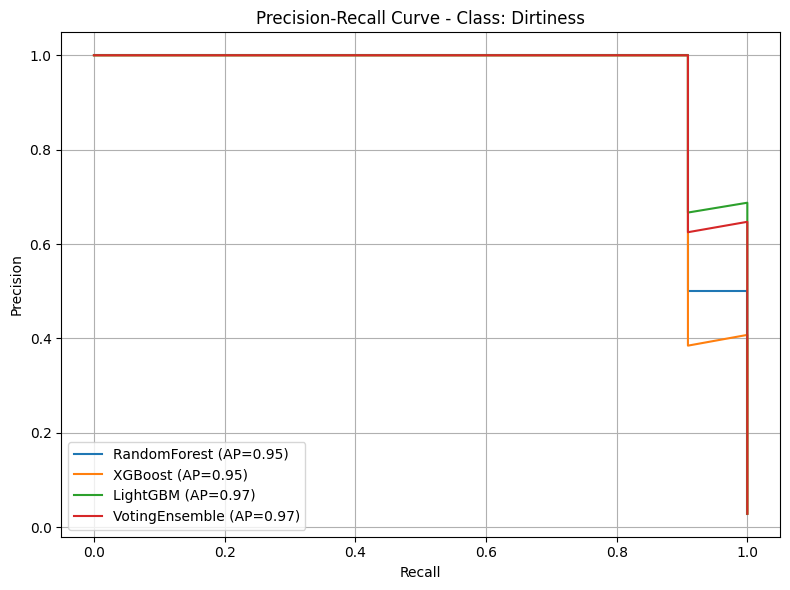

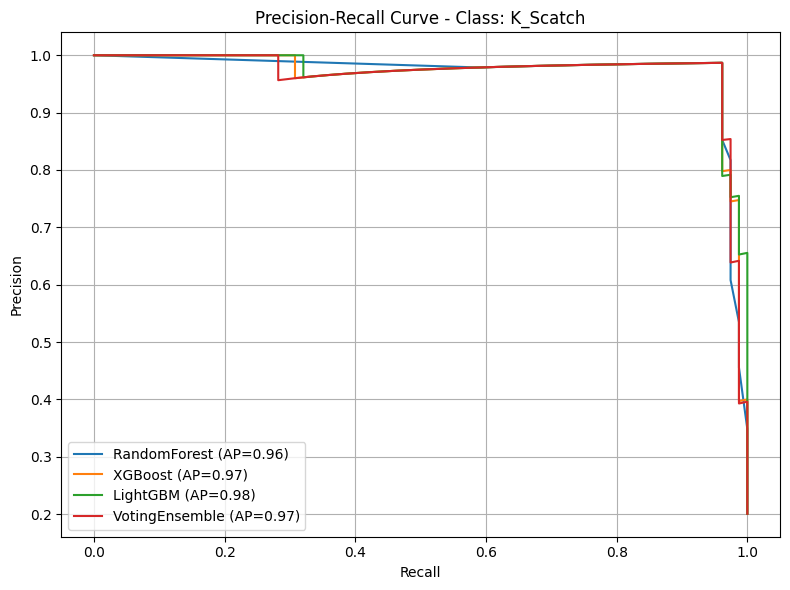

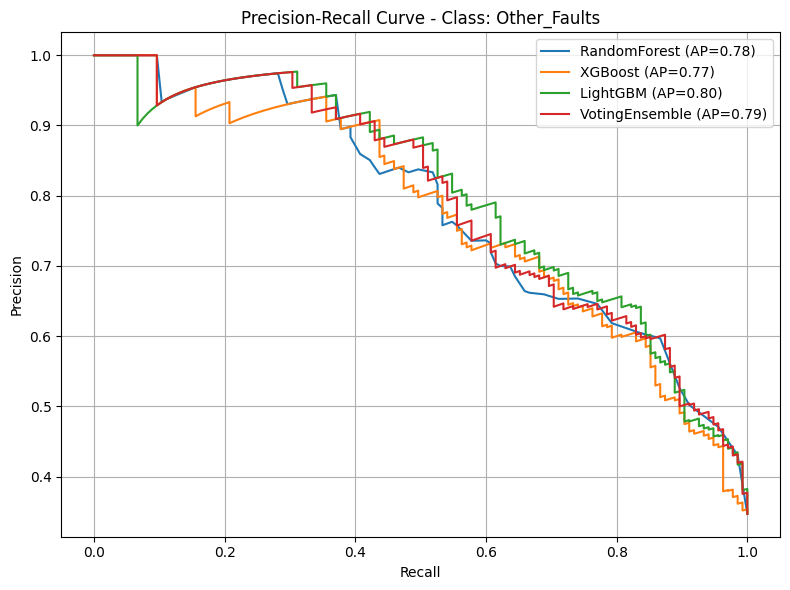

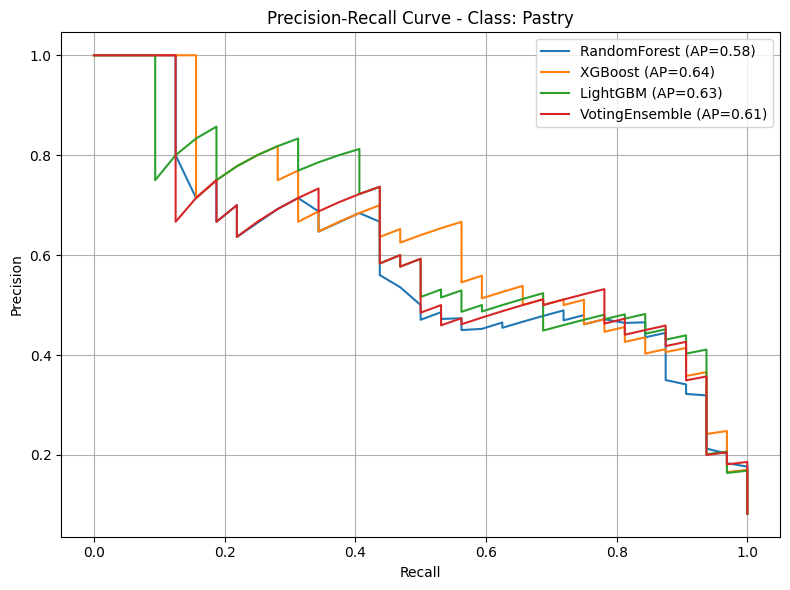

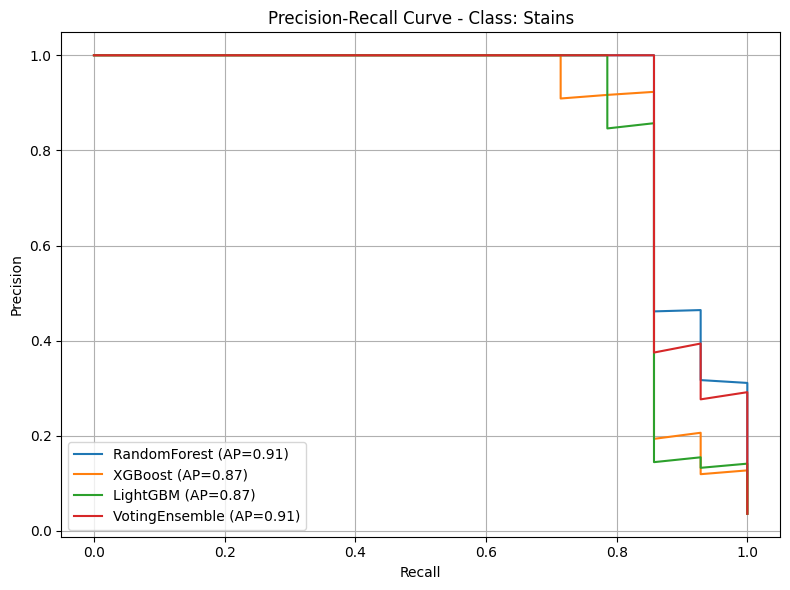

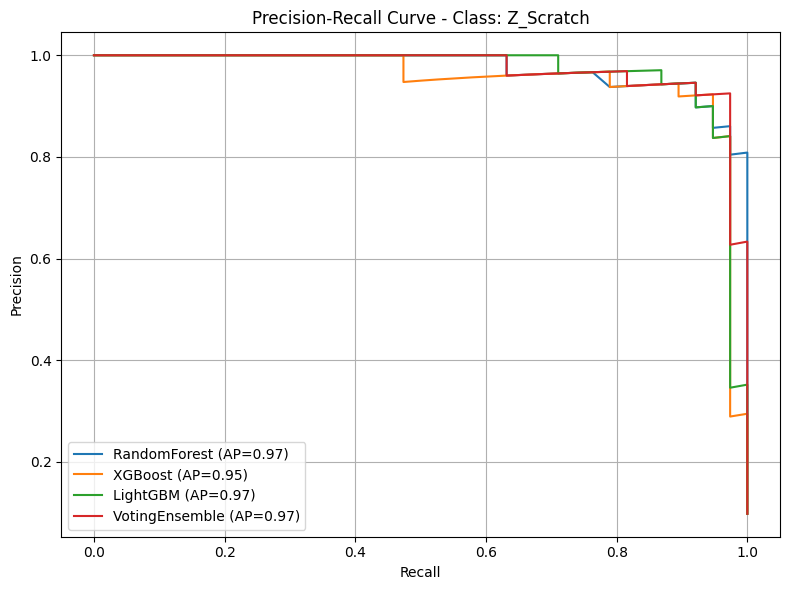

In [126]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_pr_curve(models, X_test, y_test_enc, label_encoder):
    y_bin = label_binarize(y_test_enc, classes=np.unique(y_test_enc))
    n_classes = y_bin.shape[1]

    for class_idx in range(n_classes):
        class_name = label_encoder.inverse_transform([class_idx])[0]  # 🔁 類別轉換
        plt.figure(figsize=(8, 6))
        for name, model in models.items():
            y_score = model.predict_proba(X_test)[:, class_idx]
            y_true = y_bin[:, class_idx]
            precision, recall, _ = precision_recall_curve(y_true, y_score)
            ap = average_precision_score(y_true, y_score)
            plt.plot(recall, precision, label=f"{name} (AP={ap:.2f})")

        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curve - Class: {class_name}")
        plt.legend(loc="best")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


plot_pr_curve(models, X_test_reduced, y_test_enc, le)

### 🔎 Precision-Recall 曲線分析（PR Curve）

#### 🔹 什麼是 PR 曲線？
PR 曲線描繪的是：
- **X 軸**：Recall（召回率）
- **Y 軸**：Precision（精確率）

它能幫助我們理解在不同分類閾值下，模型能多準確地找出目標類別，尤其適用於 **類別不平衡任務**（例如工業瑕疵偵測）。

---

#### 📈 Macro-average PR Curve（整體平均）

![Macro PR](roc_macro_average.png)

- 每條線代表一個模型的所有類別平均 PR 表現（macro-average）
- `LightGBM` 與 `VotingEnsemble` 表現最好（mAP = 0.85）
- 整體 precision 與 recall 均維持在 0.7~0.95 間，分類能力穩定

---

#### 🔍 各類別 Precision-Recall Curve 比較

| 類別 | 圖片 | 模型表現 | 解釋 |
|------|------|-----------|-------|
| **Bumps** | ![Bumps](roc_class_0.png) | LightGBM 最佳（AP = 0.73） | 類別具挑戰性，整體精確率略低於其他類 |
| **Dirtiness** | ![Dirtiness](roc_class_1.png) | LightGBM / Ensemble（AP = 0.97） | 幾乎完美分類，模型能高度識別 |
| **K_Scratch** | ![K_Scratch](roc_class_2.png) | LightGBM（AP = 0.98） | 非常清楚的特徵界線，分類準確度極高 |
| **Other_Faults** | ![Other](roc_class_3.png) | LightGBM（AP = 0.80） | 可預測但仍有一定混淆率 |
| **Pastry** | ![Pastry](roc_class_4.png) | XGBoost 表現較佳（AP = 0.64） | 為最具挑戰的類別之一，Precision 明顯波動 |
| **Stains** | ![Stains](roc_class_5.png) | RF / Ensemble（AP = 0.91） | 類別邊界明顯，分類效果優秀 |
| **Z_Scratch** | ![Z_Scratch](roc_class_6.png) | RF / Ensemble（AP = 0.97） | 表現接近完美，AP 接近 1.0 |

---

#### ✅ 分析總結

- `LightGBM` 與 `VotingEnsemble` 在多數類別中有較高的 AP（Average Precision）
- **Pastry 類別表現最弱**，建議進一步調整特徵或加入資料增強（Data Augmentation）
- **Z_Scratch / K_Scratch / Dirtiness / Stains** 類別辨識度高，可放心用於預測

---

#### 📌 AP 值參考指標

| AP 值範圍 | 解讀                             |
|-----------|----------------------------------|
| 0.90~1.00 | 幾乎完美分類                    |
| 0.80~0.89 | 非常穩定，模型可靠              |
| 0.70~0.79 | 還可以，可能需優化資料或特徵    |
| 0.60~0.69 | 可接受，建議強化學習策略或資料 |
| < 0.60    | 弱分類能力，建議進一步分析      |

---

## SHAP 解釋
	使用 shap.TreeExplainer() 對最佳模型做 SHAP 特徵重要性解釋
	•	summary_plot（bar）
	•	summary_plot（散佈圖）


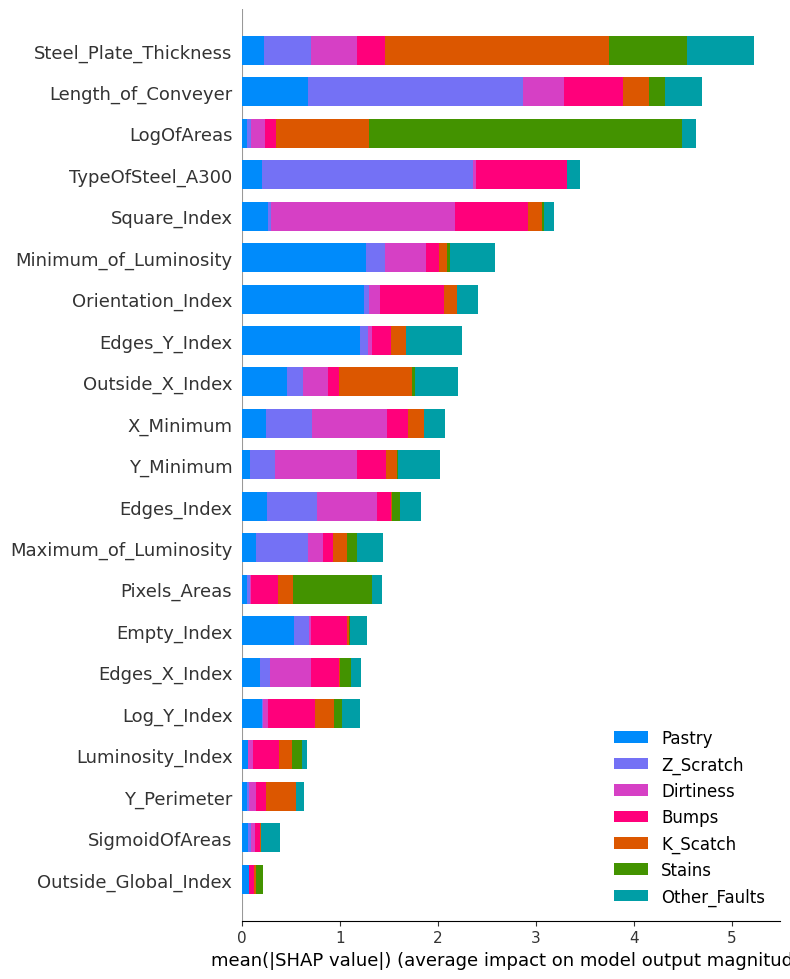

<Figure size 640x480 with 0 Axes>

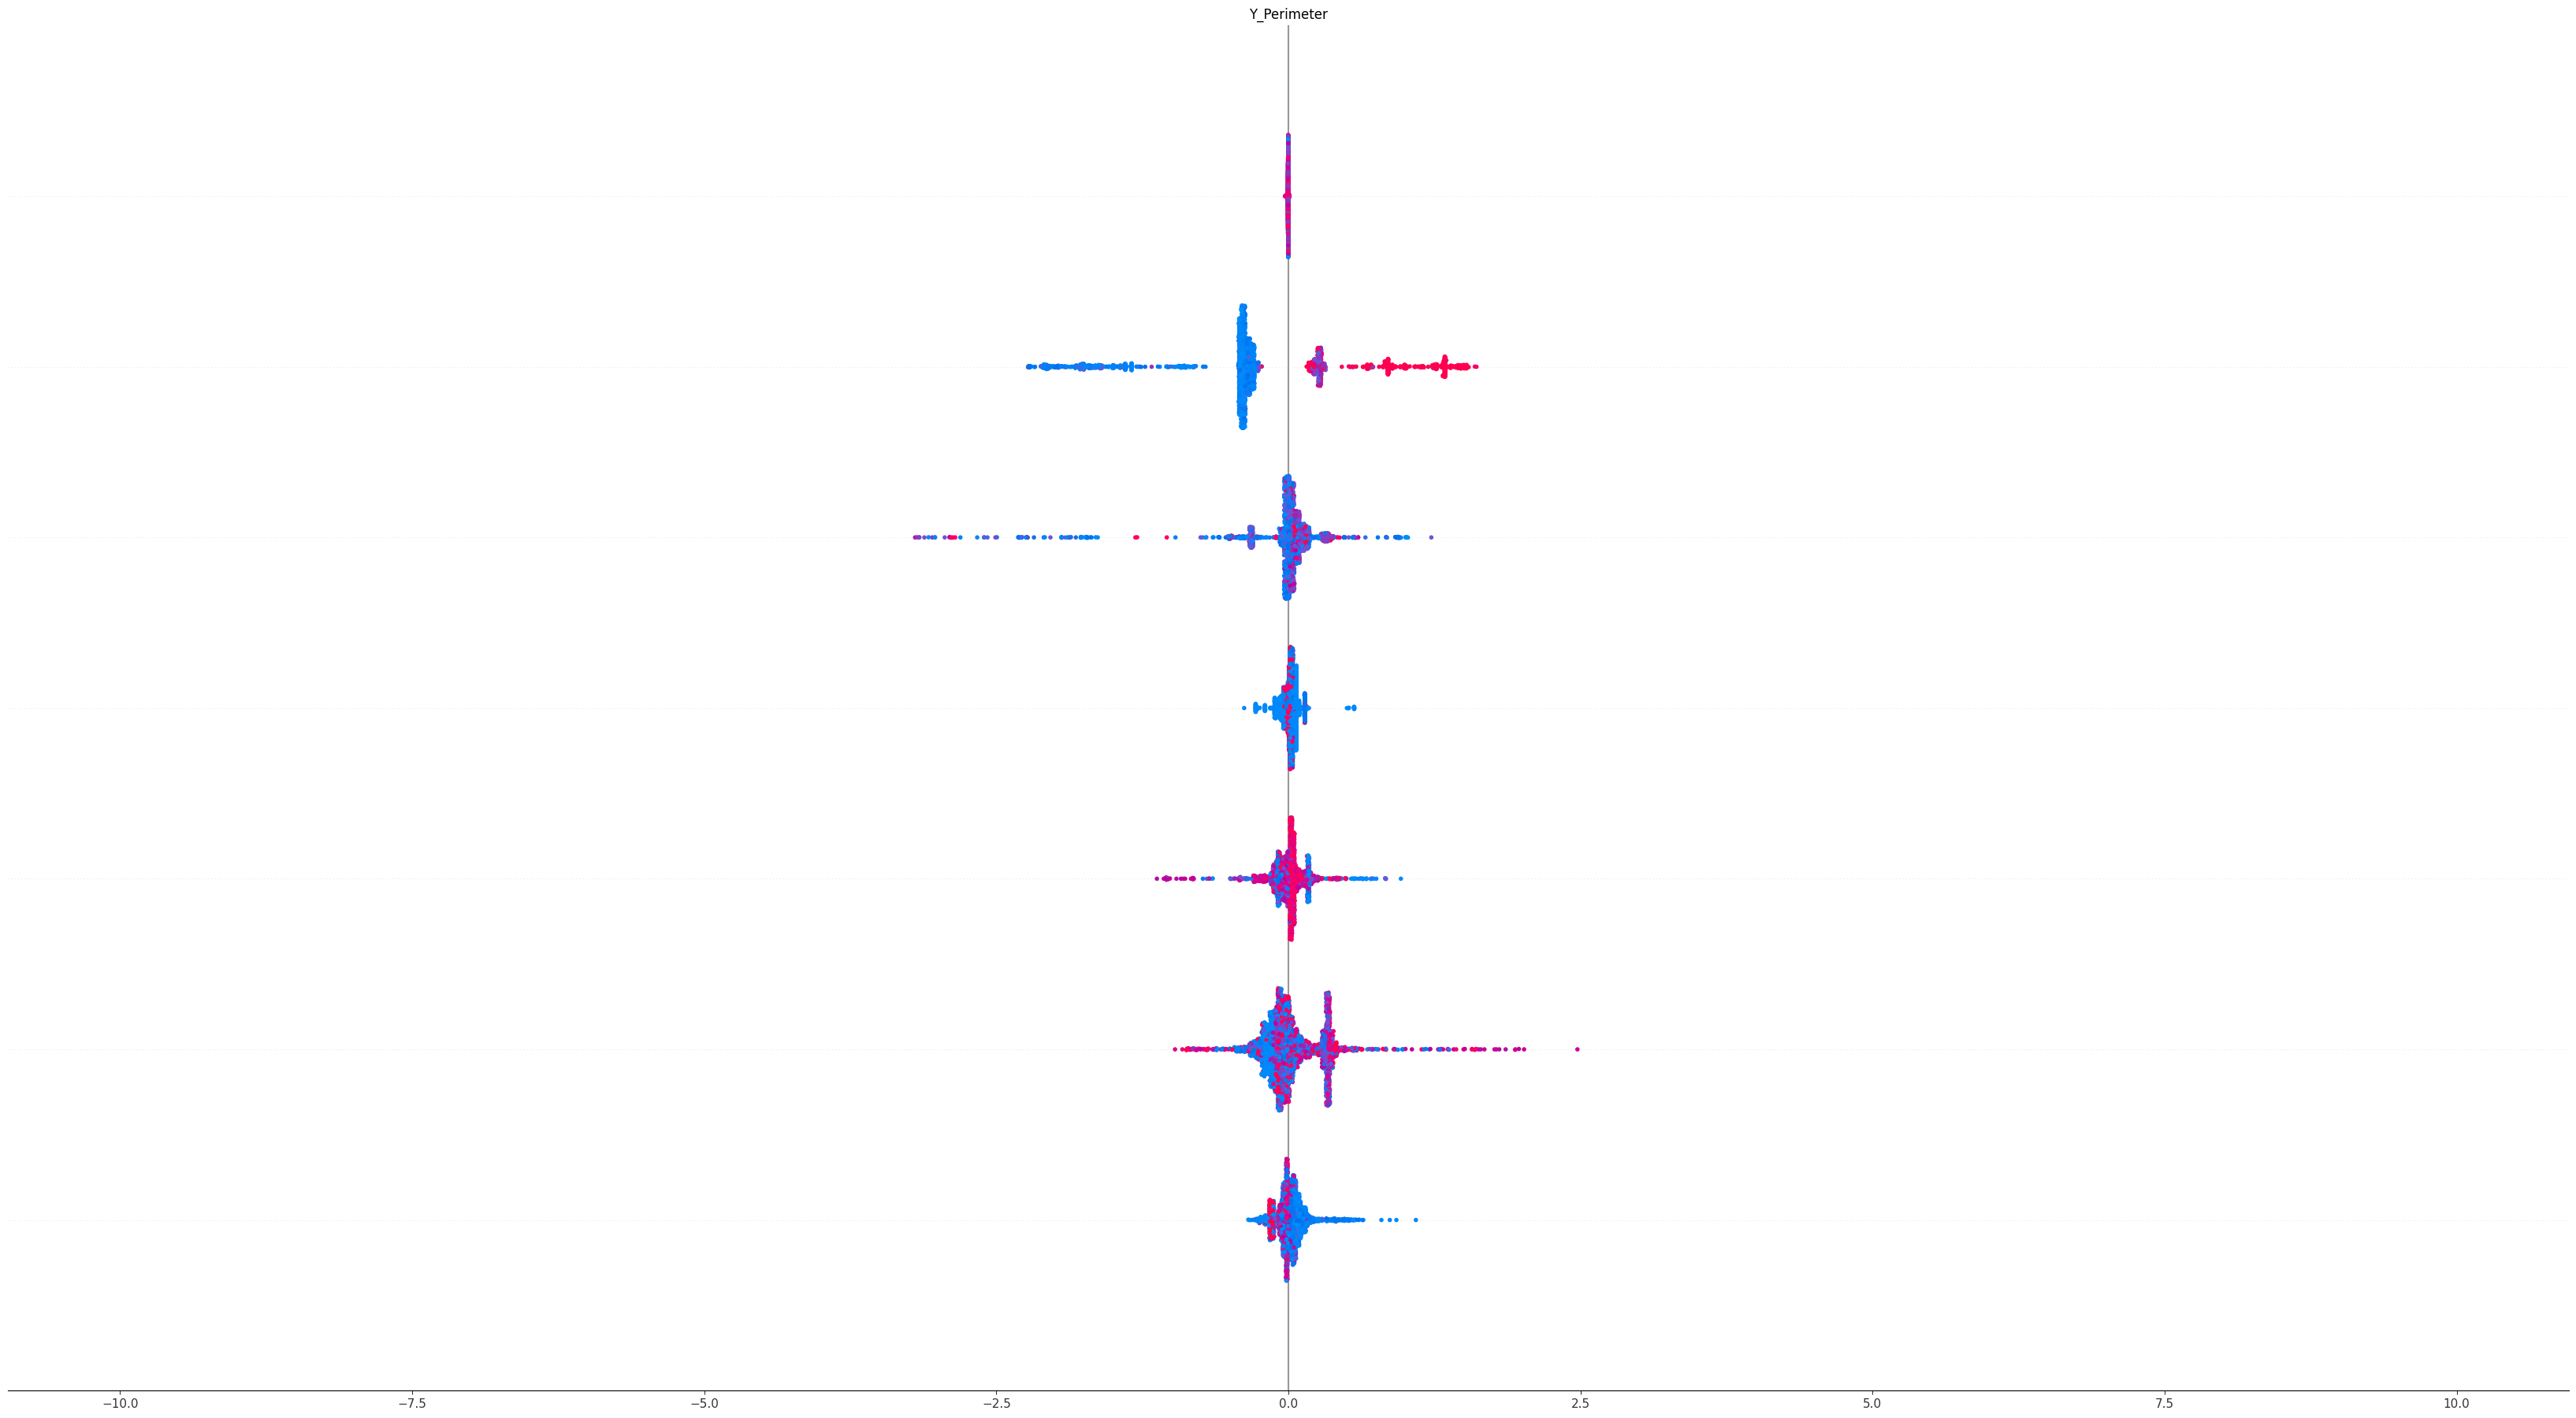

In [127]:
import shap

# 建立 explainer 並計算 shap values（多類別）
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_resampled)

# 類別名稱對應（假設你用的是 LabelEncoder le）
class_names = le.classes_.tolist()

# Bar plot with class name
shap.summary_plot(shap_values, X_resampled, plot_type="bar", class_names=class_names, max_display=X_resampled.shape[1])
# Scatter plot
shap.summary_plot(shap_values, X_resampled, class_names=class_names, max_display=X_resampled.shape[1])


### 🔍 SHAP 解釋分析：瑕疵類別多分類模型

使用 SHAP（SHapley Additive Explanations）來解釋集成分類模型（例如 LightGBM / VotingEnsemble）對每一筆資料及各個瑕疵類別的預測依據。

---

#### 📊 SHAP Summary Plot（多類別平均影響力排序）

![SHAP Summary](shap_summary_multiclass.png)

##### ✅ 解讀說明：

- **橫軸**：`mean(|SHAP value|)`，表示該特徵對模型輸出的整體平均影響力（絕對值）
- **顏色區塊**：對應不同類別（例如：Pastry、Z_Scratch、Stains...）
- **橫條越長** → 表示該特徵越關鍵

##### 🧠 特徵重要性觀察：

1. `Steel_Plate_Thickness` 是整體最具影響力的特徵，幾乎貢獻於所有類別的預測
2. `Length_of_Conveyer`, `LogOfAreas`, `TypeOfSteel_A300`、`Square_Index` 等也為跨類別的重要特徵
3. `Luminosity_Index`, `Y_Perimeter`, `SigmoidOfAreas`, `Outside_Global_Index` 為較低貢獻的特徵，可作為特徵壓縮考量

---

#### 📈 SHAP Scatter Plot：Y_Perimeter 的影響分析

![SHAP Scatter](shap_scatter_y_perimeter.png)

##### ✅ 解讀說明：

- 每個點代表一筆資料在該特徵的 SHAP 值（即該特徵對特定類別的推動力）
- **X 軸**：SHAP 值（正值 → 推高預測為某類別，負值 → 降低預測）
- **顏色**：資料點的實際類別（如 Bumps、Pastry 等）

##### 📌 分析發現：

- `Y_Perimeter` 對分類表現影響有限，大部分資料的 SHAP 值接近 0
- 對特定類別如 Pastry（藍色）、Dirtiness（紫色）仍有微弱的正向影響
- 資料分布離散，代表該特徵與其他特徵可能有交互作用，但本身影響力不顯著

---

#### 📌 總結建議：

| 特徵 | 解讀建議 |
|-------|----------|
| `Steel_Plate_Thickness` | 跨類別高貢獻，可視為全局主特徵 |
| `LogOfAreas` | 對特定類別貢獻特別高，具備類別判別價值 |
| `Y_Perimeter`, `Luminosity_Index`, `Outside_Global_Index`  | SHAP 影響力低，可評估刪除以簡化模型 |
| `Square_Index`, `TypeOfSteel_A300` | 僅部分類別依賴，適合做類別特化分析（One-vs-Rest） |

---

#### 📘 實務應用

- 可依據 SHAP 排名前 5~10 名的特徵進行：
  - 特徵選擇（精簡模型）
  - 資料視覺化（做 pairplot / UMAP）
  - 異常樣本檢查（高 SHAP 值異常樣本）

- 可搭配 PR Curve、混淆矩陣交叉分析哪些類別分類效果仍可強化